# Using machine learning to improve simulations of dynamical systems

The purpose of this notebook is to illustrate a concept for how machine learning algorithms, in particular artificial neural networks, can help to improve the simulation of dynamical systems like the Earth's atmosphere. This is illustrated using a dynamical system presented by Ed Lorenz in 1996.

## The Lorenz '96 system

This is a time-evolving system of variables arranged in a ring, intended to be analogous to a latitude circle around the Earth. The variables are divided into two types: slowly-varying $X_{k}$ and quickly-varying $Y_{j,k}$, defined for $k=1,\ldots,K$, and $j=0,\ldots,J+2$. The $Y$ variables are analogous to quantities involving small-scale phenomena like thunderstorm activity and the $X$ variables are analogous to large-scale variables, such as temperature averaged over a 100km$\times$100km area (the kind of quantity our numerical models of the atmosphere compute). The equations are:

\begin{equation}
\begin{split}
\frac{\mathrm{d}X_{k}}{\mathrm{d}t} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_{k} +F - (hc/b) \sum_{j=1}^{J} Y_{j,k}, \\
\frac{\mathrm{d}Y_{j,k}}{\mathrm{d}t} = -cbY_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - cY_{j,k} + (hc/b)X_{k},
\end{split}
\end{equation}

with cyclic boundary conditions $X_{k}=X_{k+K}$ and $Y_{j,k}=Y_{j,k+K}$ and parameter values $h=1$, $F=20$, $b=10$ and $c=4$. The $Y$ variables are connected in a ring, such that $Y_{0,k}=Y_{J,k-1}$, $Y_{J+1,k}=Y_{1,k+1}$ and $Y_{J+2,k}=Y_{2,k+1}$, so there are $J$ unique $Y_{j,k}$ variables associated with each $X_{k}$ variable. The time units are arbitrary and called model time units (MTUs). The system is defined to be integrated forwards in time using a fourth-order Runge-Kutta time-stepping scheme, with time step 0.001MTU.

The file Lorenz96.py contains code for simulating these equations.

Suppose we would like to be able to predict this system's behaviour, but cannot afford to simulate the $Y$ variables (just as we would like to predict the Earth's weather, but cannot afford to simulate every little thunderstorm).

Firstly, let's see how the $X$ variables behave in the true system.

In [1]:
#Imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from sklearn.neural_network import MLPRegressor  
    #using scikit-learn's neural networks by default - there is also the option to use tensorflow and keras below

from Lorenz96 import L96

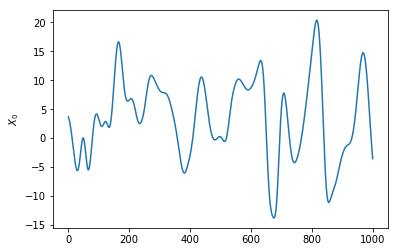

In [2]:
model_true=L96()
#run for 10MTUs, discarding the first 5 MTUs where the system is probably far from its attractor, 
#saving the state every 0.005MTUs
model_true.run(fc_length=10,save_int=0.005, discard=5)

plt.figure()
plt.plot(model_true.x_save[:,0,0])  #plotting the first X variable (they all have identical statistics)
plt.ylabel('$X_{0}$')

The model exhibits a complex behaviour, with much non-periodic variability. Now let's try simulating the system with a cheaper model that contains only the $X$ variables.

## A cheaper model
I'll use the following equations to be our computationally cheaper simulator that has been truncated (meaning the $Y$ variables have been chopped out), derived from the equation for the $X$ variables for the truth system:

\begin{equation} 
\frac{\mathrm{d}X^{*}_{k}}{\mathrm{d}t} = f_{k}(\mathbf{X*}) = -X^{*}_{k-1}(X^{*}_{k-2} - X^{*}_{k+1}) - X^{*}_{k} + F - U(X^{*}_{k})
\end{equation}

The time step is also lengthened to 0.005 (just as we cannot afford to simulate the detailed short-time scale behaviour of the Earth). The function $U(X^{*}_{k})$ is a cubic equation that crudely represents the effect of the $Y$ variables - it's derived by regressing prediction errors made when $U$ is set to zero onto the $X$ variables. I'll skip over the details here - if you're interested, see Wilks, 2005, "Effects of stochastic parametrizations in the Lorenz '96 system", $\textit{Q. J. R. Met. Soc.},$ 131, 389-407.

In anticipation of the next stage, this model will be called "No neural network" or "No-NN". Let's do a model run from the point where I started saving data from the run of the truth model.

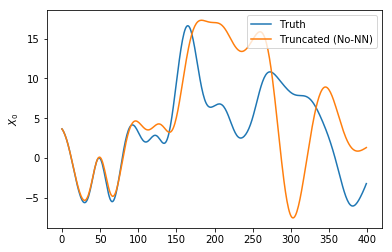

In [3]:
model_trunc_nonn=L96(param='cubic',dt=0.005,x=model_true.x_save[0])  
    #The "param='cubic'" argument specifies not to simulate the Y variables explicitly, but rather parameterise
    #them with a cubic equation.
model_trunc_nonn.run(fc_length=5,save_int=0.005)

plt.figure()
plt.plot(model_true.x_save[:400,0,0], label='Truth')
plt.plot(model_trunc_nonn.x_save[:400,0,0], label='Truncated (No-NN)')
plt.ylabel('$X_{0}$')
plt.legend(loc='upper right')

The truncated model predicts the truth system well up to about 100 time steps, and then diverges - this is expected because the system is chaotic, and any error in the simulation model, however small, will grow until the simulated behaviour becomes completely different from the true behaviour.

To get a better idea of how good the truncated model is, let's extend the run lengths to 200MTU in total and compare the mean and standard deviation of the $X$ values in the simulations, disregarding the first 10MTU so the initial condition is forgotten. (A counter will print out to show the progress of the runs - notice that the truncated model runs much faster than the true system.)

In [4]:
long_run_length=200
print('Doing truth model run')
model_true.run(fc_length=long_run_length-5,save_int=0.005)
print('Doing truncated No-NN model run')
model_trunc_nonn.run(fc_length=long_run_length-5,save_int=0.005)

Doing truth model run
t = 10.0
t = 20.0
t = 30.0
t = 40.0
t = 50.0
t = 60.0
t = 70.0
t = 80.0
t = 90.0
t = 100.0
t = 110.0
t = 120.0
t = 130.0
t = 140.0
t = 150.0
t = 160.0
t = 170.0
t = 180.0
t = 190.0
t = 200.0
Doing truncated No-NN model run
t = 10.0
t = 20.0
t = 30.0
t = 40.0
t = 50.0
t = 60.0
t = 70.0
t = 80.0
t = 90.0
t = 100.0
t = 110.0
t = 120.0
t = 130.0
t = 140.0
t = 150.0
t = 160.0
t = 170.0
t = 180.0
t = 190.0


In [5]:
truth_mean=model_true.x_save[2000:].mean()  
truth_sd=model_true.x_save[2000:].std()
trunc_nonn_mean=model_trunc_nonn.x_save[2000:].mean()
trunc_nonn_sd=model_trunc_nonn.x_save[2000:].std()
    #the first 2000 saved states, corresponding to 10MTU, are not used, so the truncated model gets no advantage
    #from starting from the same initial condition as the Truth model.
print('Truth:             Mean={:.2f}, Standard deviation={:.2f}'.format(truth_mean, truth_sd))
print('Truncated (No-NN): Mean={:.2f}, Standard deviation={:.2f}'.format(trunc_nonn_mean, trunc_nonn_sd))

Truth:             Mean=3.59, Standard deviation=6.44
Truncated (No-NN): Mean=3.79, Standard deviation=6.07


The truncated model does not perform too badly. But let's see if this can be improved with some machine learning. 

## Using neural networks to correct the output of the truncated model
Training an algorithm to learn to simulate a system as complex as the Earth from scratch would be a huge challenge. Instead, let's think about just correcting the error of our truncated model - we might expect it to be possible to achieve better performance without needing hugely complicated algorithms.

I will get the errors of the truncated model when predicting single time steps, and train neural networks to learn these errors (for one $X$ variable at a time, using the same neural network for each, since they behave identically), to use in models that look like:

\begin{equation}
\frac{\mathrm{d}X^{*}_{k}}{\mathrm{d}t} = f_{k}(\mathbf{X*}) + \epsilon_{k}(\mathbf{X*})
\end{equation}

where $\epsilon(\mathbf{X*})$ is the output of the neural network. (It's not realistic to get errors for every time step in the case of simulating Earth, but it simplifies things for this demonstration - to simulate a more realistic situation, the systems would need to be trained to produce sequences of changes over time steps that are at least as long as the typical gaps between observations.)

In [6]:
#Get errors of predictions of the truncated model for forecasting ahead by single time steps.

x_ten_true=(model_true.x_save[1:,0,:]-model_true.x_save[:-1,0,:])/model_true.save_int  #true single time step changes

#Make a new instance of the no-NN model, taking the states along the truth model's trajectory as initial conditions
model_trunc_nonn2=L96(param='cubic',dt=0.005,x=model_true.x_save[:-1,:,:])

#Predict the single time step changes
x_ten_trunc_nonn_predict=model_trunc_nonn2.dxdt()

x_ten_err=x_ten_true-x_ten_trunc_nonn_predict[:,0,:]  #the prediction errors

Now train the neural networks. In this case, the neural networks will use the $X$ variables up to two points away from the location where the prediction is being made (this number is not particularly special).

I'll use just the first half of the data from the truth model, and save the second half for validation. I'll leave a buffer of 10MTUs (2000 time steps) between the two, so no data in the training dataset is related to that in the validation dataset through persistence. 

In [7]:
delta_x_input=2  #setting the maximum distance of the input data in X-space

x_ten_err_train=x_ten_err[:(model_true.x_save.shape[0]/2-2000)]
model_true_x_train=model_true.x_save[:x_ten_err_train.shape[0],:,:]
x_ten_true_train=x_ten_true[:x_ten_err_train.shape[0]]  #for use later

#Create the validation data as well, to use later.
x_ten_err_valid=x_ten_err[model_true.x_save.shape[0]/2:]
model_true_x_valid=model_true.x_save[model_true.x_save.shape[0]/2:model_true.x_save.shape[0]/2+x_ten_err_valid.shape[0]]
x_ten_true_valid=x_ten_true[model_true.x_save.shape[0]/2:]

#So the training doesn't take too long, I'll thin the data, and use just 4000 points in the time series
n_pts=4000
thin_factor=model_true_x_train.shape[0]/n_pts
x_thinned=np.squeeze(model_true_x_train[::thin_factor,:])
x_ten_err_thinned=np.squeeze(x_ten_err_train[::thin_factor,:])

#Make an array with X-values wrapped around
x_wrap=np.zeros((x_thinned.shape[0],)+(8+2*delta_x_input,))
x_wrap[:,delta_x_input:-delta_x_input]=x_thinned[:,:]
x_wrap[:,:delta_x_input]=x_thinned[:,-delta_x_input:]
x_wrap[:,-delta_x_input:]=x_thinned[:,:delta_x_input]

#Combine the dimensions corresponding to time and the X-direction
x_train=np.zeros(x_thinned.shape+(2*delta_x_input+1,))
for i in range(8):
    x_train[:,i,:]=x_wrap[:,i:i+2*delta_x_input+1]
x_train=x_train.reshape((x_thinned.shape[0])*8, 2*delta_x_input+1)

y_train=x_ten_err_thinned.reshape((x_thinned.shape[0])*8)

#Scale the inputs to have mean zero and standard deviation 1, since this tends to improve neural network 
#performance (LeCun, Bottou, Orr and Muller, 2012)
x_train_mean=x_train.mean()
x_train_std=x_train.std()
x_train_scaled=(x_train-x_train_mean)/x_train_std

For this demo, I'll just train neural networks with withs of 16 and 1 or 2 hidden layers. I'll use the ReLu activation function.

In [8]:
#Enter depths (numbers of hidden layers) and widths of the layers to try here - every combination of depth and width 
#is tested
depths=[1,2]  
widths=[16]

#Training with scikit-learn
nn_dict={}
for d in depths:
    nn_dict[d]={}
    for w in widths:
        print 'Training neural network with depth {:d} and width {:d}'.format(d,w)
        hidden_layer_sizes=(w,)*d
        nn=MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=10000,              
                        tol=1e-4, activation='relu', random_state=1)  #set random_state to make results reproducible
        nn.fit(x_train_scaled,y_train)
        nn_dict[d][w]=nn

#Alternative - try training with tensorflow by uncommenting the code below
"""import tensorflow as tf
import keras

nn_dict={}
for d in depths:
    nn_dict[d]={}
    for w in widths:
        print 'Training neural network with depth {:d} and width {:d}'.format(d,w)
        nn=tf.keras.models.Sequential()
        for i in range(d):
            nn.add(tf.keras.layers.Dense(w,activation=tf.nn.relu))
        nn.add(tf.keras.layers.Dense(1))  #an output layer with linear activation function

        nn.compile(optimizer='adam',loss='mean_squared_error')
        
        #Use stoppping criterion to stop training when loss doesn't improve by at least 0.05 for 2 epochs.
        #(This tolerance is set fairly high, but it just stops it taking too long for this demonstration.)
        callbacks = [ keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.05, patience=2, verbose=0) ]
        nn.fit(x_train_scaled, y_train, epochs=1000, callbacks=callbacks)
        
        nn_dict[d][w]=nn
        
        print('')"""
print('')

Training neural network with depth 1 and width 16
Training neural network with depth 2 and width 16



Let's compare the size of the prediction errors of the models with neural networks with those of the truncated model on the training dataset, and also on the second half of the truth time series, which I'll use for validation.

In [9]:
#Print the errors of the truncated model
model_trunc_nonn_train=L96(param='cubic',dt=0.005,x=model_true_x_train[::thin_factor])
x_ten_predict_trunc_nonn_train=model_trunc_nonn_train.dxdt()
x_ten_err_trunc_nonn_train=x_ten_true_train[::thin_factor]-x_ten_predict_trunc_nonn_train[:,0,:]
x_ten_err_rmse_trunc_nonn_train=np.sqrt(np.mean(x_ten_err_trunc_nonn_train**2))

model_trunc_nonn_valid=L96(param='cubic',dt=0.005,x=model_true_x_valid)
x_ten_predict_trunc_nonn_valid=model_trunc_nonn_valid.dxdt()
x_ten_err_trunc_nonn_valid=x_ten_true_valid-x_ten_predict_trunc_nonn_valid[:,0,:]
x_ten_err_rmse_trunc_nonn_valid=np.sqrt(np.mean(x_ten_err_trunc_nonn_valid**2))

print('{:47} RMSE train={:.2f} RMSE valid={:.2f}'
      .format('Error for truncated no-NN model:',x_ten_err_rmse_trunc_nonn_train,x_ten_err_rmse_trunc_nonn_valid))
print('')

model_nn_errs={}  #for saving the model RMSEs
x_ten_err_nn_dict={}  #for saving the model predictions on the validation dataset for later
for d in depths:
    model_nn_errs[d]={}
    x_ten_err_nn_dict[d]={}
    for w in widths:
        model_nn_errs[d][w]={}
        
        #Create the model for each neural network. Note that the mean and standard deviation of the training
        #data are used as inputs. This is because the X-variables need to be transformed as above before being 
        #used as inputs to the neural network, and the same values should be used as when training the neural
        #networks to avoid using information from outside the training dataset.
        model_nn_train=L96(param='NN_err',dt=0.005,x=model_true_x_train[::thin_factor],
                           nn=nn_dict[d][w], nn_x_train_mean=x_train_mean, nn_x_train_std=x_train_std, 
                           nn_delta_x_input=delta_x_input)
        x_ten_predict_nn_train=model_nn_train.dxdt()
        x_ten_err_nn_train=x_ten_true_train[::thin_factor]-x_ten_predict_nn_train[:,0,:]
        x_ten_err_rmse_nn_train=np.sqrt(np.mean(x_ten_err_nn_train**2))
        model_nn_errs[d][w]['RMSE train']=x_ten_err_rmse_nn_train
        

        model_nn_valid=L96(param='NN_err',dt=0.005,x=model_true_x_valid,
                           nn=nn_dict[d][w], nn_x_train_mean=x_train_mean, nn_x_train_std=x_train_std, 
                           nn_delta_x_input=delta_x_input)
        x_ten_predict_nn_valid=model_nn_valid.dxdt()
        x_ten_err_nn_dict[d][w]=x_ten_predict_nn_valid
        x_ten_err_nn_valid=x_ten_true_valid-x_ten_predict_nn_valid[:,0,:]
        x_ten_err_rmse_nn_valid=np.sqrt(np.mean(x_ten_err_nn_valid**2))
        model_nn_errs[d][w]['RMSE valid']=x_ten_err_rmse_nn_valid

        print('{:47} RMSE train={:.2f} RMSE valid={:.2f}'
              .format('Error for model with neural network (d={:d} w={:d}):'.format(d,w),
                      x_ten_err_rmse_nn_train,x_ten_err_rmse_nn_valid))


Error for truncated no-NN model:                RMSE train=2.46 RMSE valid=2.10

Error for model with neural network (d=1 w=16): RMSE train=1.82 RMSE valid=1.44
Error for model with neural network (d=2 w=16): RMSE train=1.76 RMSE valid=1.38


This is seen more clearly when plotted using bar charts.

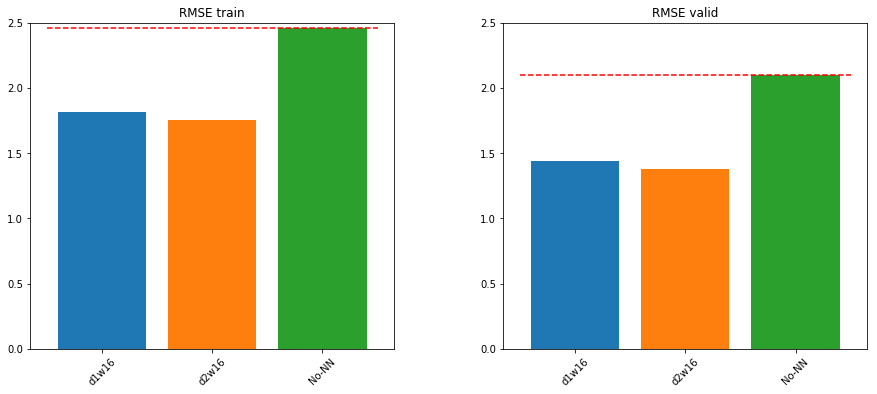

In [10]:
fig,axarr=plt.subplots(1,2, figsize=(15,6))

nbars=1+len(depths)*len(widths)

trunc_nonn_errs={'RMSE train':x_ten_err_rmse_trunc_nonn_train, 'RMSE valid':x_ten_err_rmse_trunc_nonn_valid}
for i,stat in enumerate(['RMSE train','RMSE valid']):
    bar_heights=[model_nn_errs[d][w][stat] for d in depths for w in widths]+[trunc_nonn_errs[stat]]
    barx=np.arange(1,1+nbars)
    bar_labels=['d{:d}w{:}'.format(d,w) for d in depths for w in widths]+['No-NN']
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    axarr[i].bar(barx, bar_heights, color=colors)
    axarr[i].set_xticks(barx)
    axarr[i].set_xticklabels(bar_labels)
    for tick in axarr[i].get_xticklabels():
        tick.set_rotation(45)
    #dashed line showing value for truncated No-NN model
    axarr[i].plot([np.min(barx)-0.5, np.max(barx)+0.5],[trunc_nonn_errs[stat],trunc_nonn_errs[stat]], 'r--')
    axarr[i].set_title(stat)
    axarr[i].set_ylim([0,2.5])

fig.subplots_adjust(wspace=0.3)

The results I get show that the neural networks have reduced the root mean square error of the single time step predictions in both the training and validation data in all cases, by up to about 35% - quite a considerable improvement. The validation scores are actually less than the scores on the training dataset, so the neural networks don't appear to have been overfit - this can happen if the truth system happened to go through states that are more predictable in the period used for validation, as is indicated to be the case by the RMSE for the No-NN model for the validation dataset also being lower. (This indicates that I could try using larger neural networks - this does indeed give improved results, but for this demo I've stuck with small neural networks to keep computational time down.)

Let's check that the neural networks don't sometimes lead to very wrong predictions (which could be hidden by an aggregate RMSE statistic) by plotting the predicted against the true single-timestep changes in the validation dataset.

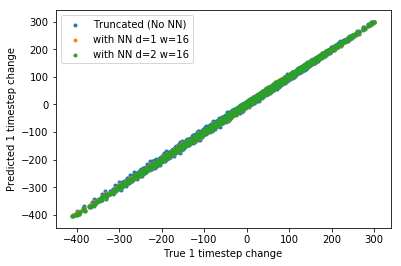

In [11]:
plt.figure()
#make plot for the original truncated model, for comparison.
plt.scatter(x_ten_true_valid, x_ten_predict_trunc_nonn_valid[:,0,:], marker='.', label='Truncated (No NN)') 
for d in depths:
    for w in widths:
        plt.scatter(x_ten_true_valid, x_ten_err_nn_dict[d][w][:,0,:], marker='.', 
                    label='with NN d={:d} w={:d}'.format(d,w))
plt.legend(loc='upper left')
plt.xlabel('True 1 timestep change')
plt.ylabel('Predicted 1 timestep change')

The predictions from the models with neural networks are always close to the true values, so they seem to be behaving reasonably reliably.

How about their ability to follow the trajectory of the true system? Let's see how they do at the prediction test I ran before.

Doing run for model with neural network with depth 1 and width 16
Doing run for model with neural network with depth 2 and width 16


(0, 575)

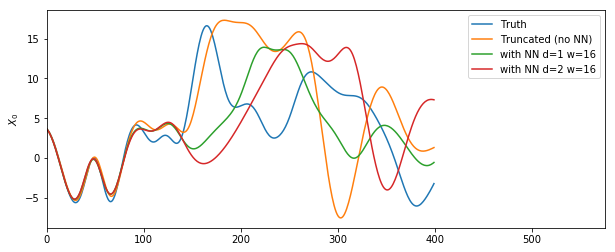

In [12]:
model_nn_dict={}  #for saving the models using each neural network and their associated simulations
for d in depths:
    model_nn_dict[d]={}
    for w in widths:
        print('Doing run for model with neural network with depth {:d} and width {:d}'.format(d,w))
        model_nn=L96(param='NN_err',dt=0.005,x=model_true.x_save[0],
                     nn=nn_dict[d][w], nn_x_train_mean=x_train_mean, nn_x_train_std=x_train_std, 
                     nn_delta_x_input=delta_x_input)
        model_nn.run(fc_length=5,save_int=0.005)
        model_nn_dict[d][w]=model_nn

plt.figure(figsize=(10,4))
plt.plot(model_true.x_save[:400,0,0], label='Truth')
plt.plot(model_trunc_nonn.x_save[:400,0,0], label='Truncated (no NN)')
for d in depths:
    for w in widths:
        plt.plot(model_nn_dict[d][w].x_save[:400,0,0], label='with NN d={:d} w={:d}'.format(d,w))
plt.ylabel('$X_{0}$')
plt.legend(loc='upper right')
plt.xlim(0,575)  #making room for the legend

The predictions follow the true trajectory similarly well to the original truncated system, before diverging due to chaotic behaviour, and exhibiting similar variability to the truth model. All of the simulation models share some biases, for example overpredicting the $X_{0}$ value between about time steps 100-130, suggesting that this is due to not simulating the $Y$ variables explicitly.

It's not possible to tell from this one case whether the neural networks are giving better overall simulation properties, so let's now see if they've improved the ability to simulate the statistics of the true system in long runs. As well as the mean and standard deviation, I've included the Kolmogorov-Smirnov (KS) distance measure of how similar the frequency distribution of the simulated $X$ variables are in the truncated models to those in the true system.

In [13]:
#Do long runs with the models with neural networks
for d in depths:
    for w in widths:
        print('Doing long run for model with neural network with depth {:d} and width {:d}'
              .format(d,w))
        model_nn=model_nn_dict[d][w]
        model_nn.run(fc_length=long_run_length-5,save_int=0.005)

#As a reminder, print the mean and standard deviation of the long time series produced using the truth model 
#and the truncated model. Also calculate the Kolmogorov-Smirnov statistic, quantifying the difference between the 
#frequency distributions of X-values in the two systems (smaller is better).
print('')
print('{:37} Mean={:.2f}  Standard deviation={:.2f}'
      .format('Truth:'.format(d,w),truth_mean, truth_sd))
print('')

#Calculating the KS statistic for the truncated model with no neural network
trunc_nonn_ks=scipy.stats.ks_2samp(model_true.x_save[2000:].ravel(),model_trunc_nonn.x_save[2000:].ravel())[0]
print('{:37} Mean={:.2f}  Standard deviation={:.2f}  KS distance={:.3f}'
      .format('Truncated:'.format(d,w),trunc_nonn_mean, trunc_nonn_sd, trunc_nonn_ks))
print('')

#Now print the statistics for the models with neural networks
model_nn_stats={}  #saving for later
for d in depths:
    model_nn_stats[d]={}
    for w in widths:
        model_nn=model_nn_dict[d][w]
        model_nn_stats[d][w]={}
        model_nn_stats[d][w]['mean']=model_nn.x_save[2000:].mean()
        model_nn_stats[d][w]['sd']=model_nn.x_save[2000:].std()
        model_nn_stats[d][w]['KS distance']= \
            scipy.stats.ks_2samp(model_true.x_save[2000:].ravel(),model_nn.x_save[2000:].ravel())[0]
        print('{:37} Mean={:.2f}  Standard deviation={:.2f}  KS distance={:.3f}'
              .format('Model with neural network (d={:d} w={:d}):'.format(d,w),
                      model_nn_stats[d][w]['mean'],model_nn_stats[d][w]['sd'],model_nn_stats[d][w]['KS distance']))


Doing long run for model with neural network with depth 1 and width 16
t = 10.0
t = 20.0
t = 30.0
t = 40.0
t = 50.0
t = 60.0
t = 70.0
t = 80.0
t = 90.0
t = 100.0
t = 110.0
t = 120.0
t = 130.0
t = 140.0
t = 150.0
t = 160.0
t = 170.0
t = 180.0
t = 190.0
Doing long run for model with neural network with depth 2 and width 16
t = 10.0
t = 20.0
t = 30.0
t = 40.0
t = 50.0
t = 60.0
t = 70.0
t = 80.0
t = 90.0
t = 100.0
t = 110.0
t = 120.0
t = 130.0
t = 140.0
t = 150.0
t = 160.0
t = 170.0
t = 180.0
t = 190.0

Truth:                                Mean=3.59  Standard deviation=6.44

Truncated:                            Mean=3.79  Standard deviation=6.07  KS distance=0.024

Model with neural network (d=1 w=16): Mean=3.79  Standard deviation=6.09  KS distance=0.022
Model with neural network (d=2 w=16): Mean=3.79  Standard deviation=6.11  KS distance=0.023


Again, this is seen more clearly when plotted using bar charts.

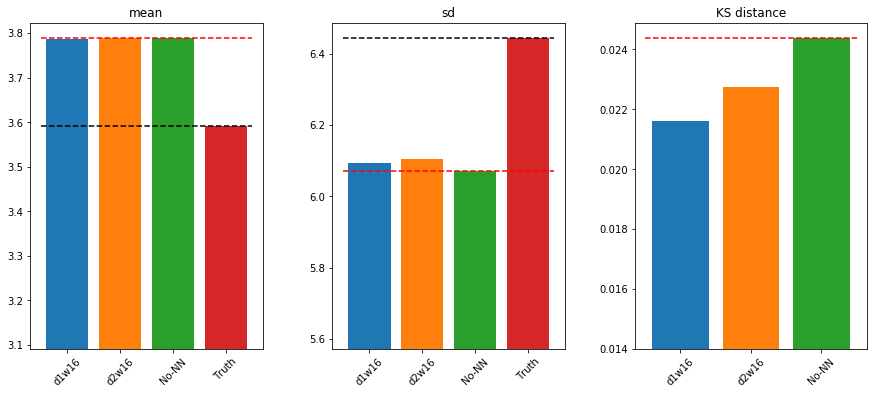

In [14]:
fig,axarr=plt.subplots(1,3, figsize=(15,6))

nbars=2+len(depths)*len(widths)
#bar_x=np.concatenate((np.arange(1,1+nbars),np.arange(3+nbars,3+nbars*2),np.arange(5+nbars*2,5+nbars*3-1)))

truth_stats={'mean':truth_mean, 'sd':truth_sd}
trunc_nonn_stats={'mean':trunc_nonn_mean, 'sd':trunc_nonn_sd, 'KS distance':trunc_nonn_ks}
for i,stat in enumerate(['mean','sd','KS distance']):
    bar_heights=[model_nn_stats[d][w][stat] for d in depths for w in widths]+[trunc_nonn_stats[stat]]
    if stat!='KS distance':
        bar_heights+=[truth_stats[stat]]
        bar_base=np.min(bar_heights)-0.5
        barx=np.arange(1,1+nbars)
    else:
        bar_base=0.014
        barx=np.arange(1,nbars)
    bar_heights=np.array(bar_heights)-bar_base
    bar_labels=['d{:d}w{:}'.format(d,w) for d in depths for w in widths]+['No-NN','Truth']
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    axarr[i].bar(barx, bar_heights, bottom=bar_base, color=colors)
    axarr[i].set_xticks(barx)
    axarr[i].set_xticklabels(bar_labels)
    for tick in axarr[i].get_xticklabels():
        tick.set_rotation(45)
    if stat!='KS distance':
        #dashed line showing value for Truth model
        axarr[i].plot([np.min(barx)-0.5, np.max(barx)+0.5],[truth_stats[stat],truth_stats[stat]], 'k--') 
    #dashed line showing value for truncated No-NN model
    axarr[i].plot([np.min(barx)-0.5, np.max(barx)+0.5],[trunc_nonn_stats[stat],trunc_nonn_stats[stat]], 'r--')
    axarr[i].set_title(stat)

fig.subplots_adjust(wspace=0.3)

When I run this code, the models with neural networks have mean values of the $X$ variables that are close to that of the original truncated model, but they yield a higher standard deviation that is closer to the true value. The KS distance comes out correspondingly smaller. (Results could differ on other computers if the seeding of random numbers happens differently compared to what happens on mine. In general, because I'm not using particularly long runs here to diagnose the statistics of the models' output, random variability in the results can be considerable - "long_run_length" needs to be increased considerably to overcome this variability. Tests I've done using much longer runs do show that neural networks robustly help to increase the standard deviation of the $X$ variables and give a reduced KS statistic, so that they improve the statistics of the simulated climate.)

So perhaps neural networks (or other algorithms) could yield improvements in simulations of complex dynamical systems like the Earth's climate. The improvements seen here are quite modest, which may be because the original truncated model for the Lorenz '96 system without a neural network already performed quite well. There is greater potential for improvement for simulations of more complex systems like the Earth, where the errors in our current simulators are much larger relatively.

The improvement in the simulated climate is much smaller than might have been expected, given the reduction in the prediction errors for single time steps of up to about 30%. This may be because the optimal model for making predictions on short time scales is different to the optimal model for simulating the long-term statistics of the system. Ways to get bigger improvements that could be tested next could include:
- training neural networks to give better skill at predicting longer time sequences of data from the Truth system
- including hidden variables with memory, to capture behaviour like that of the $Y$ variables here - these have a memory and affect the future evolution of the system, but are not currently represented in the truncated models.